## Example of spherical projection

In [1]:
import numpy as np
import os

import matplotlib.pyplot as plt

import sys
# insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, 'utils/')
from projection_old import Projection as Proj_old
from utils_challenge import *
from utils_projections import *


Using TensorFlow backend.


In [2]:
selected_set = 'train'
file_name = '00' # GT projection

# original downloaded data
path_to_gt = 'input_data/point_clouds/' + selected_set

# path with scanner positions and normalization parameters
path_to_dict = 'input_data/parameters/'

We mapped the original point cloud names to simple ones to easy the analysis.

In [3]:
mapping_files = {
"00": "5D4KVPBP",
"01": "5D4KVPC9",
"02": "5D4KVPDO",
"03": "5D4KVPFI",
"04": "5D4KVPJE",
"05": "5D4KVPNC",
"06": "5D4KVPT5",
"07": "5D4KVPX2",
"08": "5D4KVQ0P",
"09": "5D4KVRER",
"10": "5D4KVRWC",
"11": "5D4KVT48",
"12": "5D4KVT9X",
"13": "5D4KX2ZN",
"14": "5D4KX3LW",
"15": "5D4KX3PZ",
"16": "5D4KX3VN",
"17": "5D4KX4HE",
"18": "5D4KX4QC",
"19": "5D4KX4ZE",
"20": "5D4KX56H",
"21": "5D4KX5NM",
"22": "5D4KX5WV",
"23": "5D4KX66R",
"24": "5D4KX6L3",
"25": "5D4KX6T5",
"26": "5D4KX7FN",
"27": "5D4KX7IA",
"28": "5D4KX7KT",
"29": "5D4KX7RD",
"30": "5D4KX826",
"31": "5D4KX8IR",
"32": "5D4KX8UQ",
"33": "5D4KX8Y6",
"34": "5D4KX993",
"35": "5D4KX9SY",
"36": "5D4KX9ZE",
"37": "5D4KXA0G",
"38": "5D4KXAW7",
"39": "5D4KXB8D",
"40": "5D4KXBC8",
"41": "5D4KXBTC",
"42": "5D4L1GZR",
"43": "5D4L1IQ4",
"44": "5D4L1M3I",
"45": "5D4L1QP2",
"46": "5D4L1RDR",
"47": "5D4L1TH9",
"48": "5D4L1TYC",
"49": "5D4L1WHI",
"50": "5D4L1XPJ",
"51": "5D4L1Y38",
"52": "5D4L1YDX",
"53": "5D4L2BFI",
"54": "5D4L2C9B",
"55": "5D4L2DGW",
"56": "5D4L2DTM",
"57": "5D4L2FRJ",
"58": "5D4L2G9K",
"59": "5D4LHQUX",
"60": "5D4KVPG4",
"61": "5D4KVPIN",
"62": "5D4KVPXD",
"63": "5D4KVPYD",
"64": "5D4KVQ9U",
"65": "5D4KX38L",
"66": "5D4KX3EC",
"67": "5D4KX3RR",
"68": "5D4KX3TQ",
"69": "5D4KX40Y",
"70": "5D4KX5G9",
"71": "5D4KX76F",
"72": "5D4KX9N2",
"73": "5D4KX9SD",
"74": "5D4L1JIE",
"75": "5D4L1MGO",
"76": "5D4L1P8E",
"77": "5D4L1RW5",
"78": "5D4L1TDI",
"79": "5D4L1TX7"
}

## load original point cloud 

In [4]:
width_sph = 1024
height_sph = 64
f1 = 50
f2 = 115
proj_sph = Proj_old(proj_type='front', width=width_sph, height=height_sph, fov_up=f1, fov_down=f2)

In [5]:
def load_point_cloud(path_to_file, file_name, skip_names = False):
    full_path = os.path.join(path_to_file, file_name + '.txt')
    if skip_names:
        point_cloud = np.loadtxt(full_path, skiprows=1)
    else:
        point_cloud = np.loadtxt(full_path)
    return point_cloud

In [6]:
def compute_centered_point_cloud(points):
    min_val = points.min(0)

    xmin = min_val[0]
    ymin = min_val[1]
    zmin = min_val[2]

    centered_xyz = np.zeros_like(points)
    centered_xyz[:,0] = points[:, 0] - xmin
    centered_xyz[:,1] = points[:, 1] - ymin
    centered_xyz[:,2] = points[:, 2]    
    
    return centered_xyz

In [7]:
# Method to find "closest" index in spherical projection
def min_aggregation_proj(height, width, proj, points):
    depth = np.linalg.norm(points, axis = 1)
    lidx, i_img_mapping, j_img_mapping = proj.projector.project_point(points)
    aux_depth_proj = np.full([height, width], np.inf)
    aux_idx_proj = np.full([height, width], -1)
    for k in range(len(lidx)):
        h_coor = i_img_mapping[k]
        w_coor = j_img_mapping[k]    
        #print(h_coor)
        #print(w_coor)
        #print("*")
        if depth[k] < aux_depth_proj[h_coor, w_coor]:
            aux_idx_proj[h_coor, w_coor] = k
            aux_depth_proj[h_coor, w_coor] = depth[k]
    return aux_idx_proj, [lidx, i_img_mapping, j_img_mapping]

In [8]:
ground_labeled_point_cloud = load_point_cloud(path_to_gt,  mapping_files[file_name] , skip_names = True)
xyz_labeled_point_cloud = ground_labeled_point_cloud[:,:3]
gt_labels = ground_labeled_point_cloud[:,3]

In [9]:
dict_name = os.path.join(path_to_dict, selected_set + '_dict')
laser_positions = load_obj(dict_name)

In [10]:
centered_xyz = compute_centered_point_cloud(xyz_labeled_point_cloud)
xyz_to_sensor = centered_xyz - laser_positions[file_name]
valid_idx = np.where(gt_labels > 0)[0]

In [11]:
from skimage.morphology import closing, square
from normals import estimate_normals_from_spherical_img
def compute_normals_from_depth(rho_img, height, width, fov_up, fov_down):
    #pitch=np.linspace(50.0 , 115.0, height) * (np.pi / 180.0)
    pitch=np.linspace(fov_down , fov_up, height) * (np.pi / 180.0)
    yaw=np.linspace(0, 2*np.pi, width)
    valid_pixels = rho_img > 0
    cl_img = closing(rho_img, square(3))
    img_norm = estimate_normals_from_spherical_img(rho_img,pitch,yaw,res_rho=1)
    # set to zero normals obtained due to closing operation
    for l in range(3):
        img_norm[:,:,l]=img_norm[:,:,l] * valid_pixels  
    return img_norm

In [12]:
gt_spherical = np.zeros([height_sph,width_sph])
depth_spherical = np.zeros([height_sph,width_sph])
zcoor_spherical = np.zeros([height_sph,width_sph])

aux_idx_proj, mapping = min_aggregation_proj(height_sph,width_sph,proj_sph,xyz_to_sensor)
valid_3d_idx_in_2d = np.where(aux_idx_proj > -1)
idx_in_3d = aux_idx_proj[valid_3d_idx_in_2d]
    
# fill GT projection
gt_spherical[valid_3d_idx_in_2d] = gt_labels[idx_in_3d]

# fill Z projection
z_coor = xyz_to_sensor[:,2]
zcoor_spherical[valid_3d_idx_in_2d] = z_coor[idx_in_3d]

# fill DEPTH projection
depth_values = np.linalg.norm(xyz_to_sensor, axis = 1)
depth_spherical[valid_3d_idx_in_2d] = depth_values[idx_in_3d]

# fill normals
normals_spherical = compute_normals_from_depth(depth_spherical, height_sph, width_sph, f1, f2)
normals_spherical = abs(normals_spherical)

In [13]:
color_map = {
    -1: [0, 0, 0],    # empty -> black
    0: [0, 0, 0],     # undefined -> black
    1: [255, 0, 0],   # building -> red
    2: [255, 255, 0], # car -> yellow
    3: [0, 0, 255],   # ground -> blue
    4: [0, 255, 255], # pole -> cyan
    5: [0, 255, 0]    # vegetation -> green
}

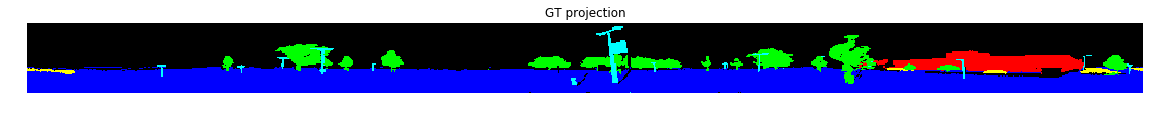

In [14]:
plt.figure(figsize=(20,20))
plt.imshow(map_gt_to_colored(gt_spherical.astype(np.uint8), color_map))
plt.title("GT projection")
plt.axis('off')
plt.show()

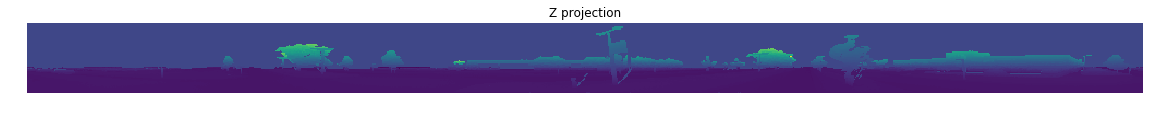

In [15]:
plt.figure(figsize=(20,20))
plt.imshow(zcoor_spherical)
plt.title("Z projection")
plt.axis('off')
plt.show()

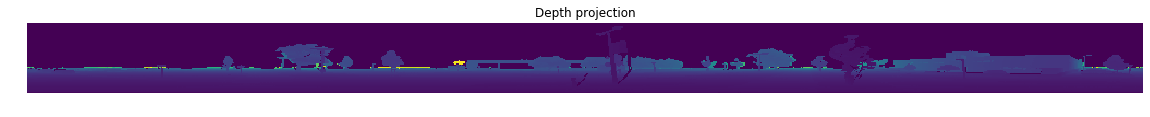

In [16]:
plt.figure(figsize=(20,20))
plt.imshow(depth_spherical)
plt.title("Depth projection")
plt.axis('off')
plt.show()

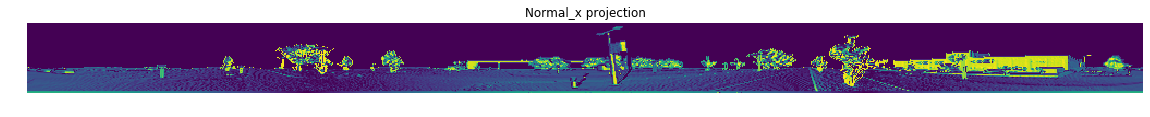

In [17]:
plt.figure(figsize=(20,20))
plt.imshow(normals_spherical[:,:,0])
plt.title("Normal_x projection")
plt.axis('off')
plt.show()

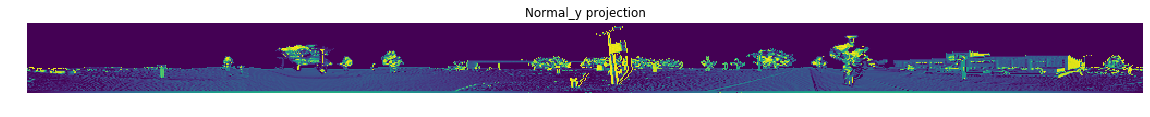

In [18]:
plt.figure(figsize=(20,20))
plt.imshow(normals_spherical[:,:,1])
plt.title("Normal_y projection")
plt.axis('off')
plt.show()

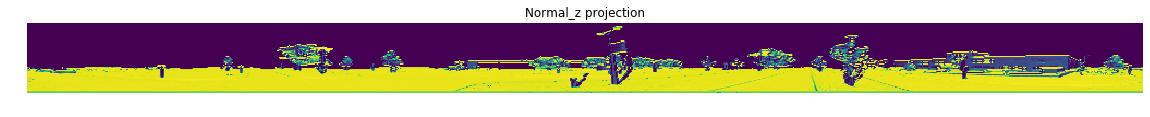

In [19]:
plt.figure(figsize=(20,20))
plt.imshow(normals_spherical[:,:,2])
plt.title("Normal_z projection")
plt.axis('off')
plt.show()

If several points were projected in same pixels, we chose the closest one to the laser.
We assigned "0" to every pixel with no points projected.


<b>Some observations: </b>

Using this approach, we computed 5 channels by each image: [Z_value, depth, Normal_x, Normal_y, Normal_z]

Z-score normalization was performed in both sequences. Mean and std was computed in train set.

Each point cloud is represented by an array of dimension [64x1024x5]